In [1]:
import numpy as np
import tables as tb
import pandas as pd

import invisible_cities.io.dst_io as dio

In [2]:
path_valid = '/lustre/ific.uv.es/ml/ific020/nexus_2021/valid_dataset_5mm.h5'
path_pred  = '/lustre/ific.uv.es/ml/ific020/nexus_2021/segmentation/marcos_trains/{}/prediction_valid_dataset.h5'

path_MC    = '/lustre/ific.uv.es/ml/ific020/nexus_2021/MC_production/' #here there are the ground MC files

In [3]:
pred_folder = 'parametros_originales'
path_pred = path_pred.format(pred_folder)

In [4]:
with tb.open_file(path_valid, 'r') as h5in:
    print(h5in)

/lustre/ific.uv.es/ml/ific020/nexus_2021/valid_dataset_5mm.h5 (File) ''
Last modif.: 'Fri Jun  4 18:28:09 2021'
Object Tree: 
/ (RootGroup) ''
/DATASET (Group) ''
/DATASET/BinsInfo (Table(100,), shuffle, zlib(4)) ''
/DATASET/EventsInfo (Table(32272,), shuffle, zlib(4)) ''
/DATASET/Voxels (Table(1672235,), shuffle, zlib(4)) ''



We first get the info of the original dataset: voxels, info of the bin sizes, and info of the mapped events to their pure MC original file

In [5]:
voxels_valid  = dio.load_dst(path_valid, 'DATASET', 'Voxels')
bininfo       = dio.load_dst(path_valid, 'DATASET', 'BinsInfo').drop_duplicates()
evinfo_valid  = dio.load_dst(path_valid, 'DATASET', 'EventsInfo')

In [6]:
voxels_valid

,xbin,ybin,zbin,energy,segclass,binclass,dataset_id
0,44,64,64,0.008756,1,0,0
1,41,56,65,0.021004,1,0,0
2,43,63,67,0.035954,1,0,0
3,41,57,64,0.008725,1,0,0
4,43,63,64,0.012181,1,0,0
...,...,...,...,...,...,...,...
1672230,7,42,102,0.030141,2,0,32271
1672231,7,43,98,0.020999,1,0,32271
1672232,22,41,87,0.018154,1,0,32271
1672233,24,44,86,0.007605,1,0,32271


In [7]:
evinfo_valid

,event_id,binclass,pathname,basename,dataset_id
0,2000000000,0,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2000_tlde.h5,0
1,2000000001,0,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2000_tlde.h5,1
2,2000000002,0,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2000_tlde.h5,2
3,2000000003,0,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2000_tlde.h5,3
4,2000000004,0,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2000_tlde.h5,4
...,...,...,...,...,...
32267,2099000343,1,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2099_tlde.h5,32267
32268,2099000344,0,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2099_tlde.h5,32268
32269,2099000345,0,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2099_tlde.h5,32269
32270,2099000346,1,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2099_tlde.h5,32270


In [8]:
bininfo

,min_x,max_x,nbins_x,min_y,max_y,nbins_y,min_z,max_z,nbins_z,Rmax
0,-220,220,89,-220,220,89,0,550,111,220


We get from bininfo some parameters of the voxel size needed to plot

In [9]:
coords = ['x', 'y', 'z']

In [10]:
start_bin = [bininfo['min_' + c].values[0] for c in coords]
final_bin = [bininfo['max_' + c].values[0] for c in coords]
numb_bins = [bininfo['nbins_' + c].values[0] for c in coords]

In [11]:
voxel_size = [(max_ - min_) / (nbin - 1) for nbin, (max_, min_) in zip(numb_bins, zip(final_bin, start_bin))]

So if we choose one event, we can obtain the MC values, the voxels, and also the prediction if we already have it

### SELECT EVENTS FOR PLOTTING

#### NUMBER OF THE SELECTED EVENT IN THE VALIDATION EVENTS FILE

In [12]:
#number of the event we want to plot
nevent = 13 

#### VOXELS OF THE EVENT

In [13]:
event_voxels = voxels_valid[voxels_valid.dataset_id == nevent]

#this is done just for a discrepancy between the numbers in the old labelling (this one) 
#and the new, from where im borrowing the functions
event_voxels = event_voxels.assign(segclass = event_voxels.segclass + 1)

#### GET INFO FROM MC FILE CORRESPONDENT TO THE SELECTED EVENT

In [14]:
select_ev_info = evinfo_valid[evinfo_valid.dataset_id == nevent]

In [15]:
#name of the MC file that contains our nevent
basename_MC = select_ev_info.basename.values[0]

#number of the event in the MC file that corresponds to the selected nevent
MC_nevent = select_ev_info.event_id.values[0]

In [16]:
full_MC_path = path_MC + basename_MC

In [17]:
with tb.open_file(full_MC_path, 'r') as h5in:
    print(h5in)

/lustre/ific.uv.es/ml/ific020/nexus_2021/MC_production/nexus_2000_tlde.h5 (File) ''
Last modif.: 'Fri Jun 17 13:21:11 2022'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(35,)) ''
/MC/hits (Table(97049,)) ''
/MC/particles (Table(27839,)) ''
/MC/sns_positions (Table(0,)) ''
/MC/sns_response (Table(0,)) ''



From here we can get the MC hits AND the MC particles that describe the event

In [18]:
MC_hits = dio.load_dst(full_MC_path, 'MC', 'hits')
MC_part = dio.load_dst(full_MC_path, 'MC', 'particles')

#### MC HITS OF THE EVENT

We label the hits for plotting, because we have just the labelled voxels

In [39]:
from next_sparseconvnet.data_io_scripts.dataset_labeling_utils import add_clf_seg_labels

In [43]:
event_hits = MC_hits[MC_hits.event_id == MC_nevent]
event_part = MC_part[MC_part.event_id == MC_nevent]

event_hits = add_clf_seg_labels(event_hits, event_part, delta_e = 0.4).merge(event_hits, on = ['event_id', 'x', 'y', 'z', 'energy'])

#this is done just for a discrepancy between the numbers in the old labelling (this one) 
#and the new, from where im borrowing the functions
event_hits = event_hits.assign(segclass = event_hits.segclass + 1)


#### LOAD PREDICTION FILE (IF WE HAVE IT)

In [25]:
voxels_pred = dio.load_dst(path_pred, 'DATASET', 'VoxelsPred')

#### PREDICTION FOR THE VOXELS OF THE EVENT

In [26]:
event_voxels_pred = voxels_pred[voxels_pred.dataset_id == nevent]

## So we now have three main dataframes:

* MC hits of the event (event_hits)
* Voxels of the event  (event_voxels)
* Predicted voxels of the event (event_voxels_pred)

# PLOT EVENT

In [27]:
from utils.plotting_utils import *

A new function for plotting voxels and hits

<IPython.core.display.Javascript object>


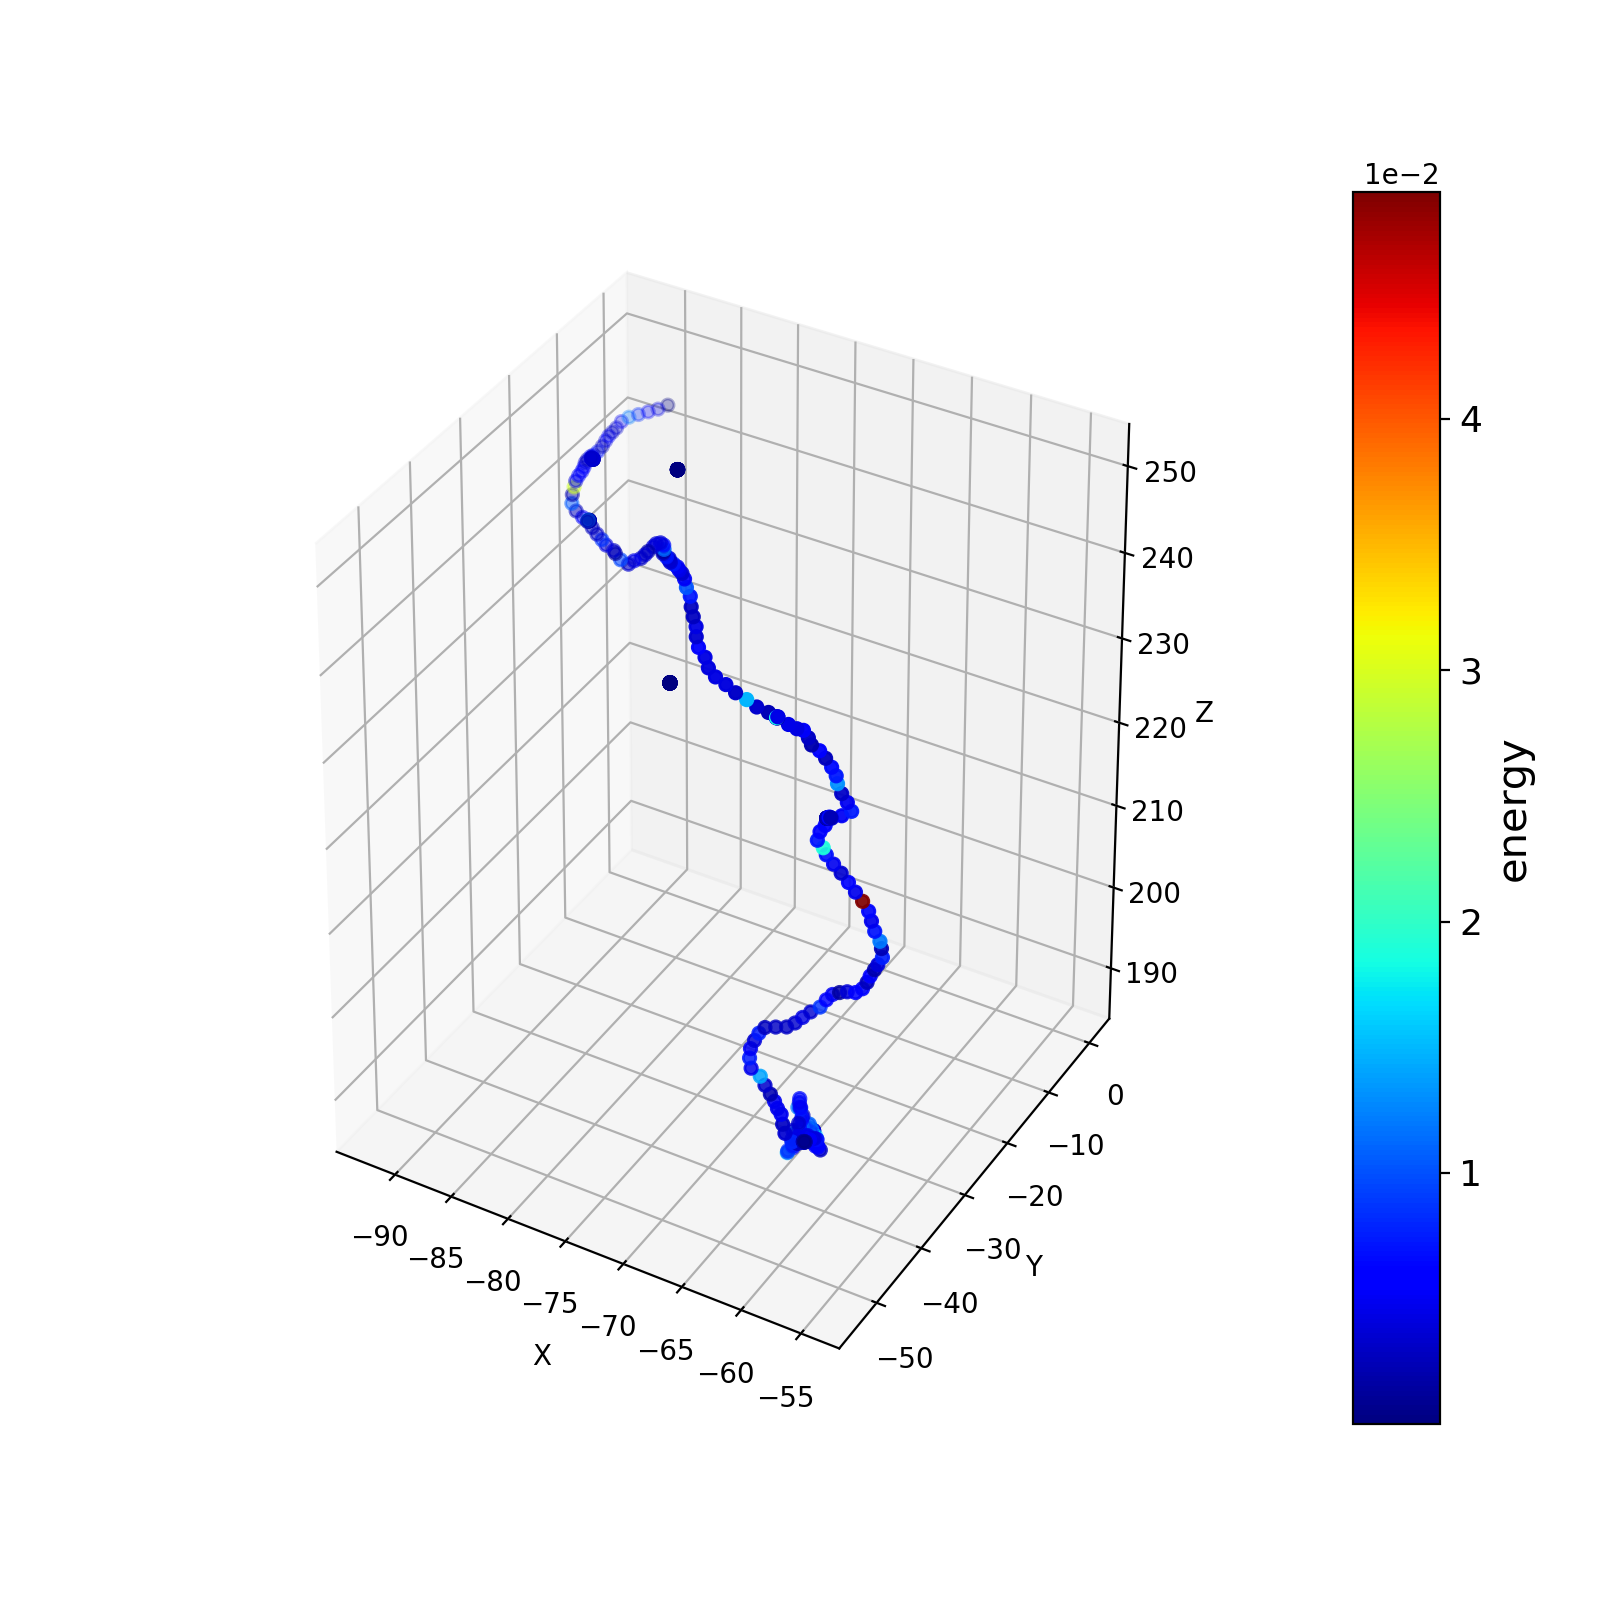

In [29]:
%matplotlib notebook
plot_3d_hits(event_hits)

<IPython.core.display.Javascript object>


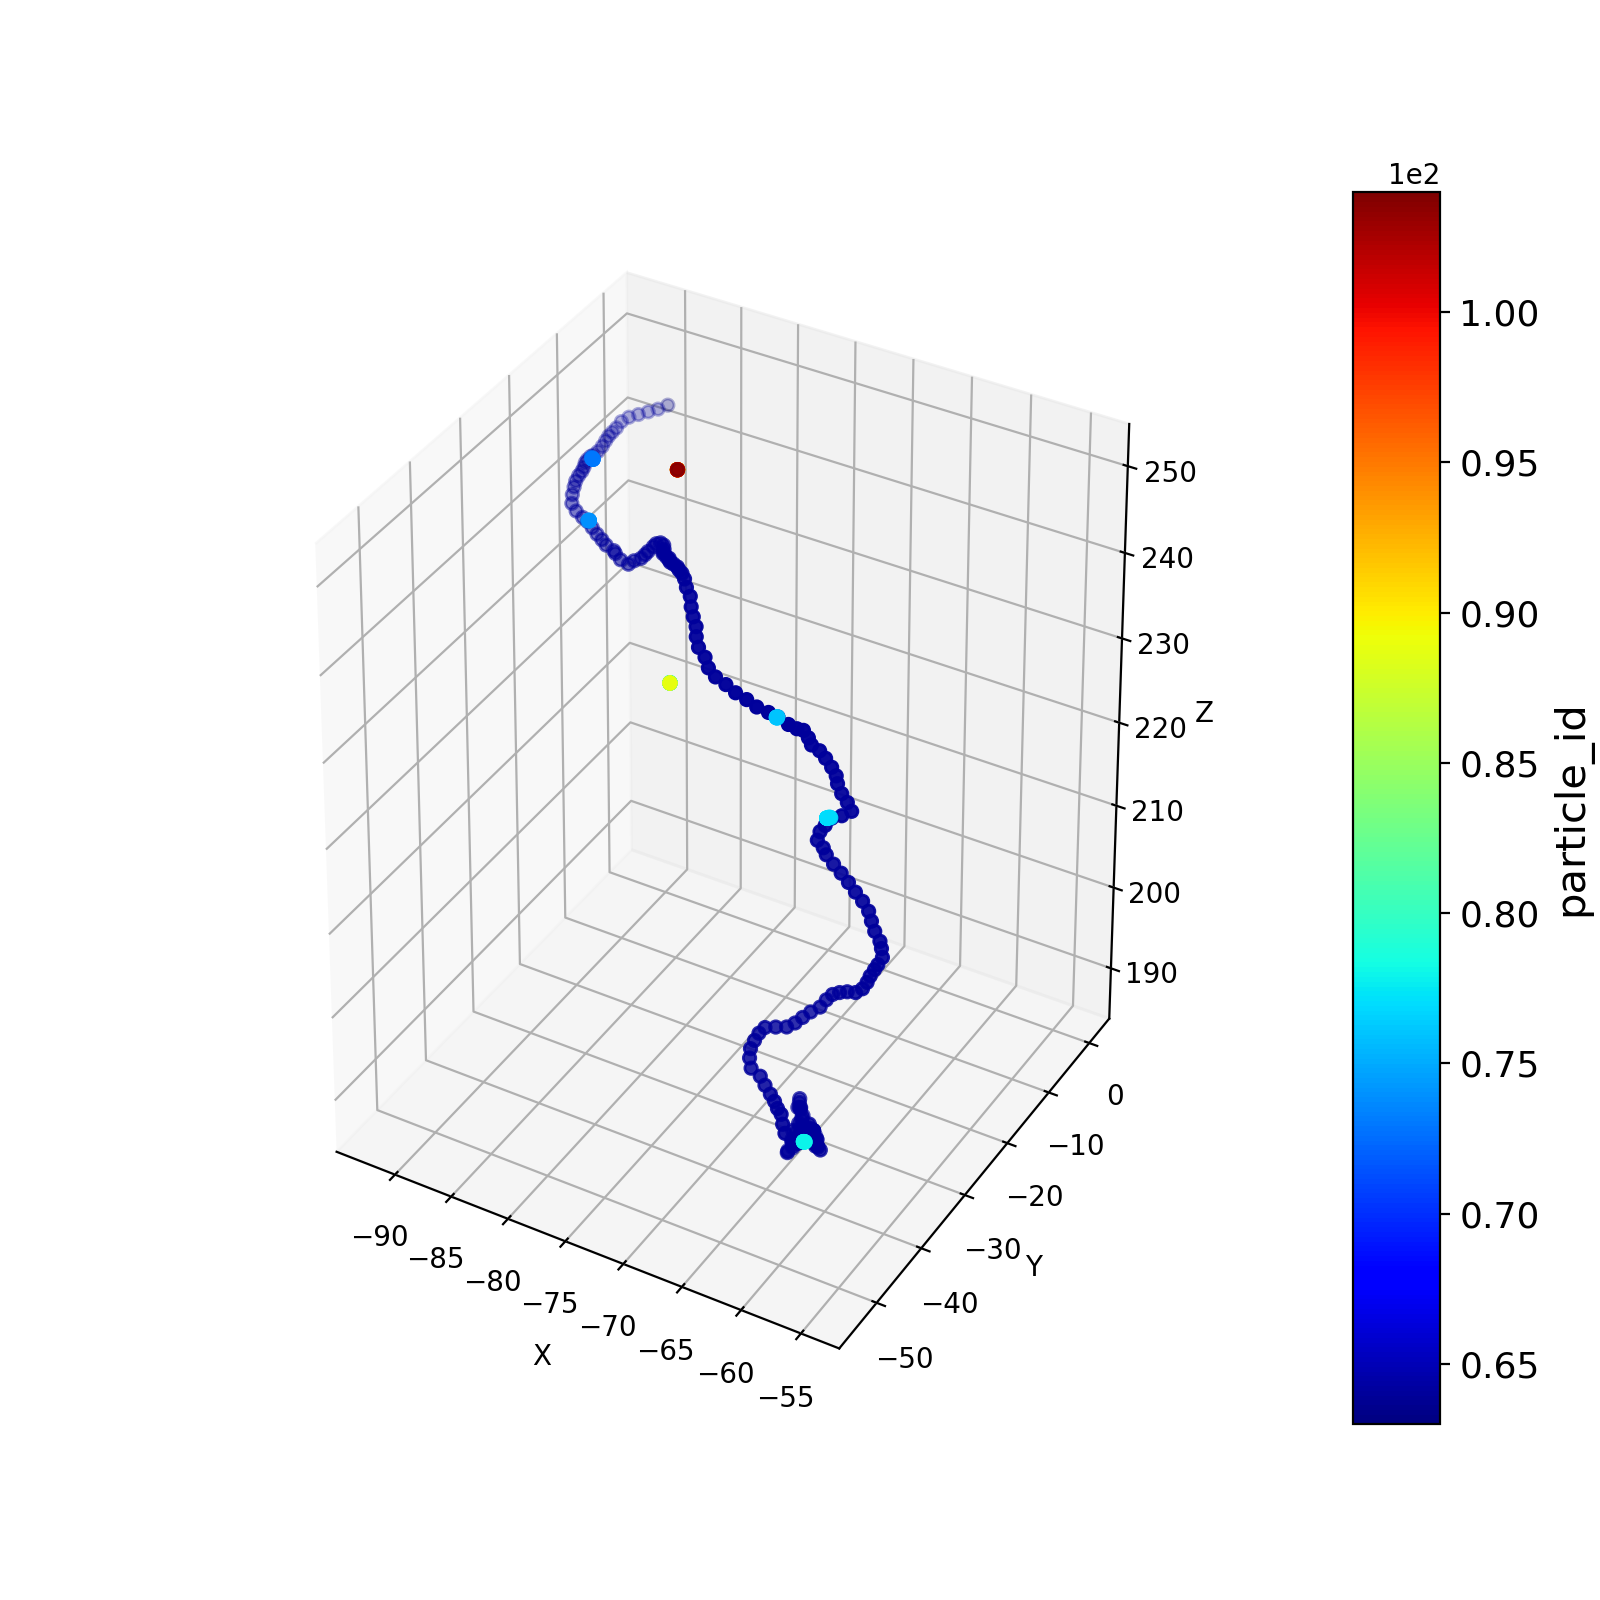

In [35]:
plot_3d_hits(event_hits, value = 'particle_id')

<IPython.core.display.Javascript object>


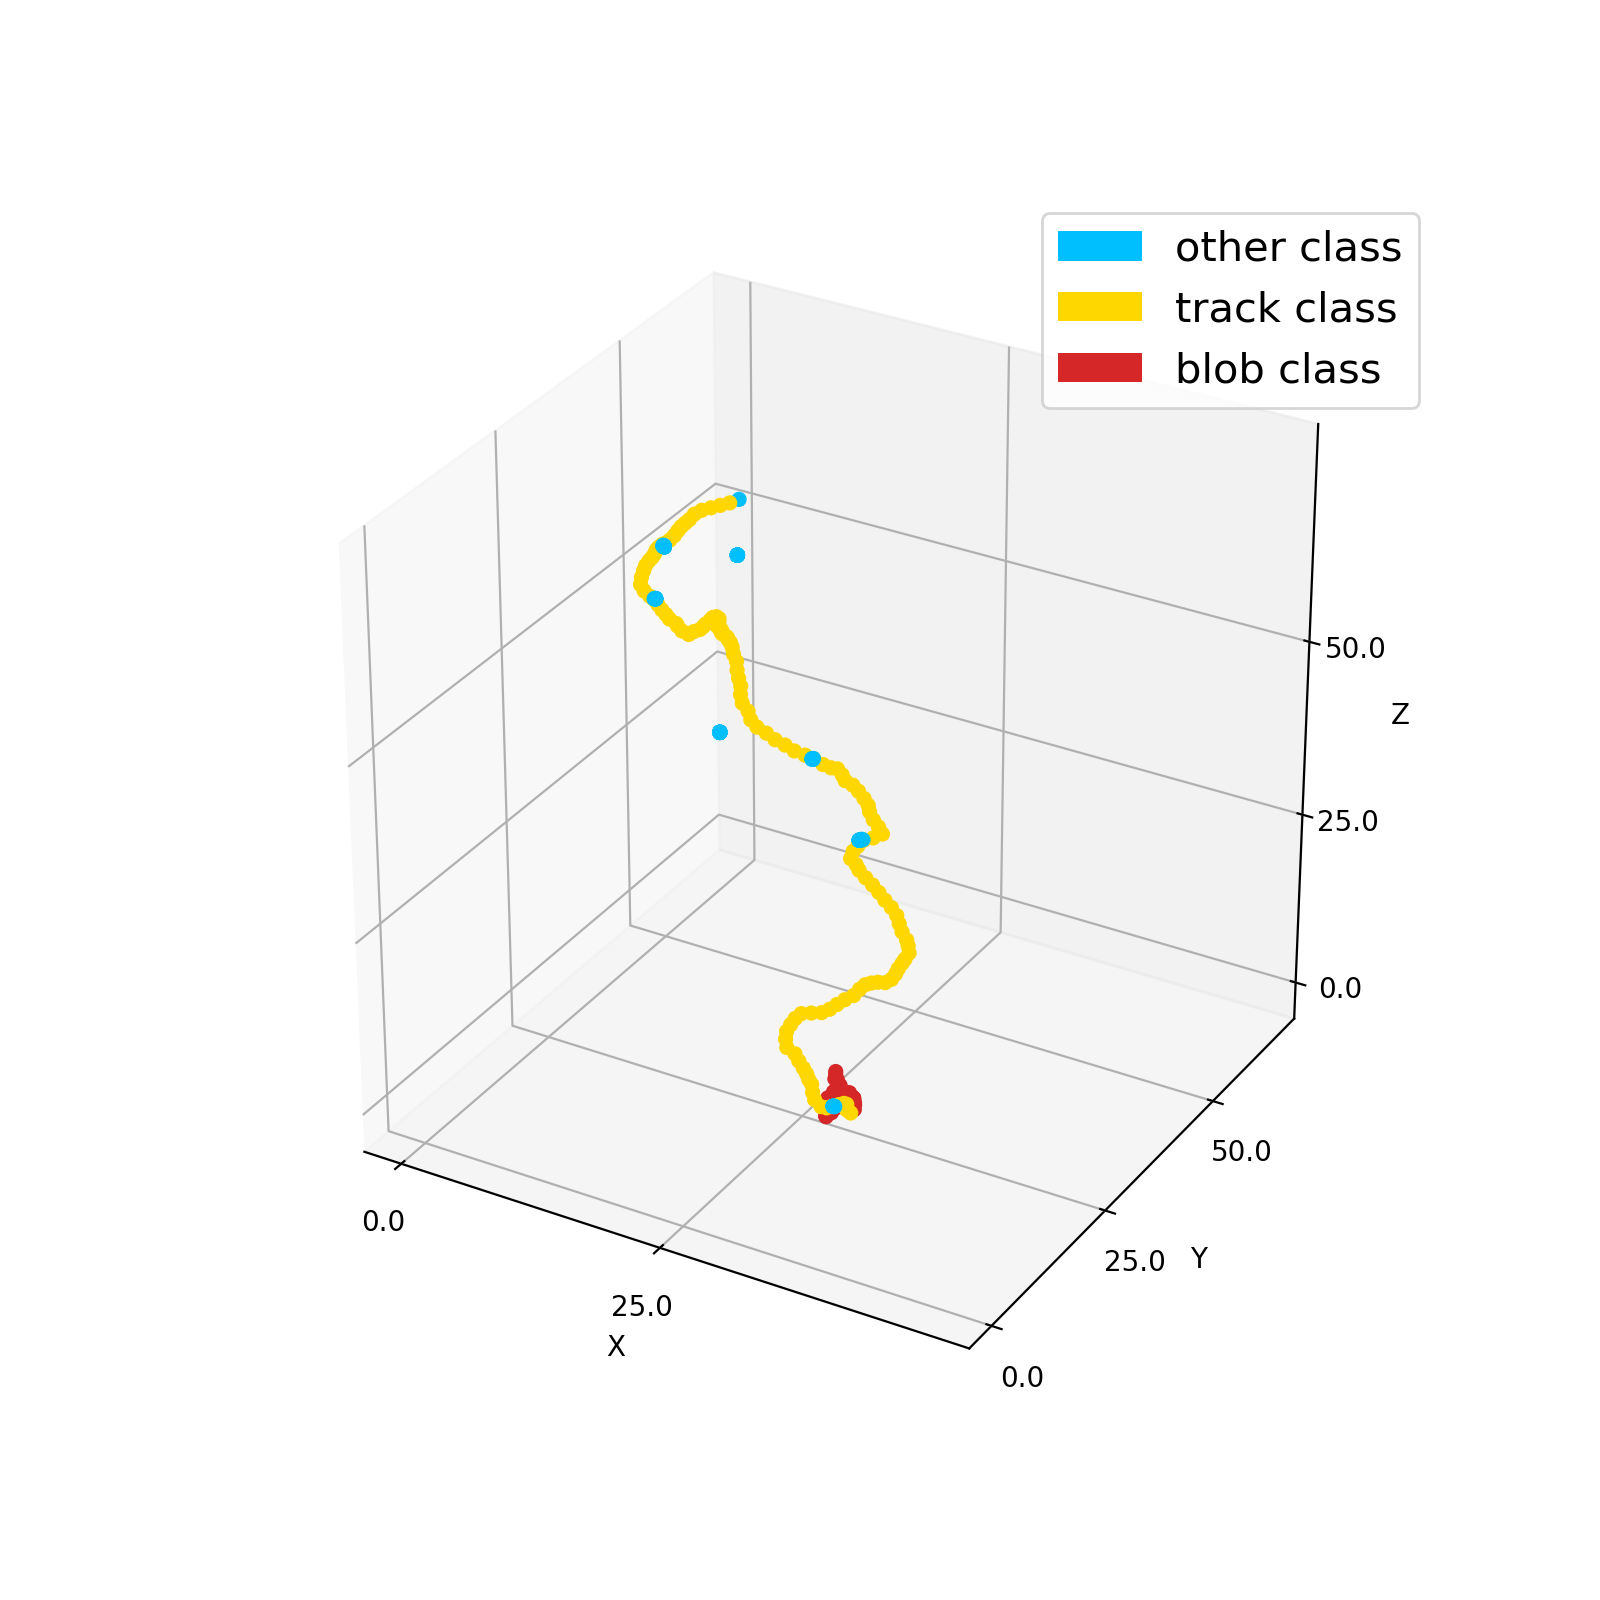

In [56]:
plot_cloud_voxels_and_hits_discrete(event_voxels, event_hits, 
                                    voxel_size, start_bin, 
                                    coords = ['xbin', 'ybin', 'zbin'], 
                                    #value = ['energy', 'energy', 'energy'],
                                    linewidth = 0,
                                    opacity = [0, 0, 1])

<IPython.core.display.Javascript object>


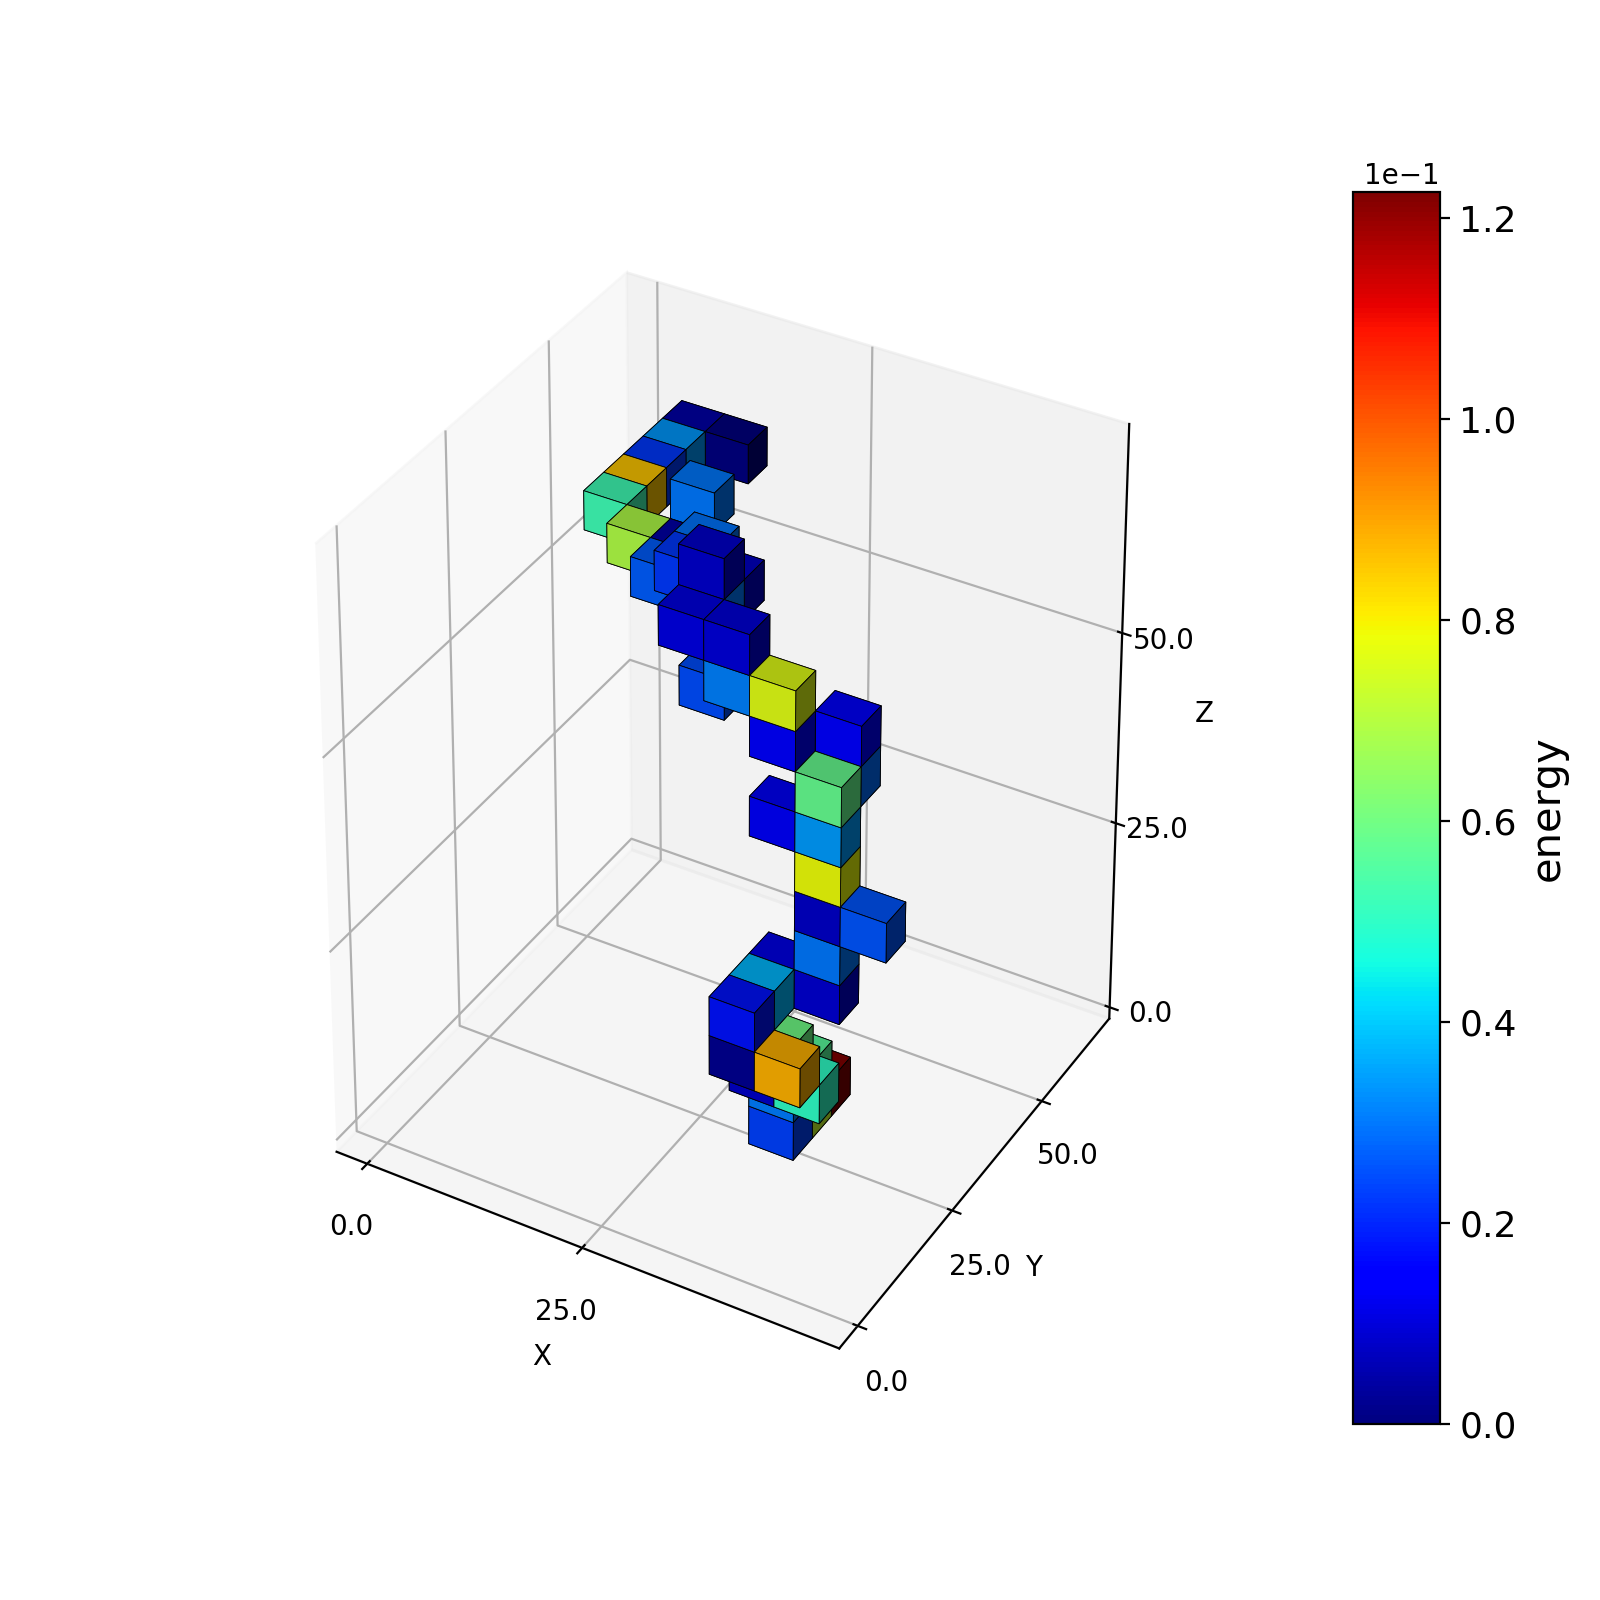

In [37]:
plot_3d_vox(event_voxels, voxel_size, 
            value='energy', 
            coords = ['xbin', 'ybin', 'zbin'], 
            cmap=mpl.cm.jet)

<IPython.core.display.Javascript object>


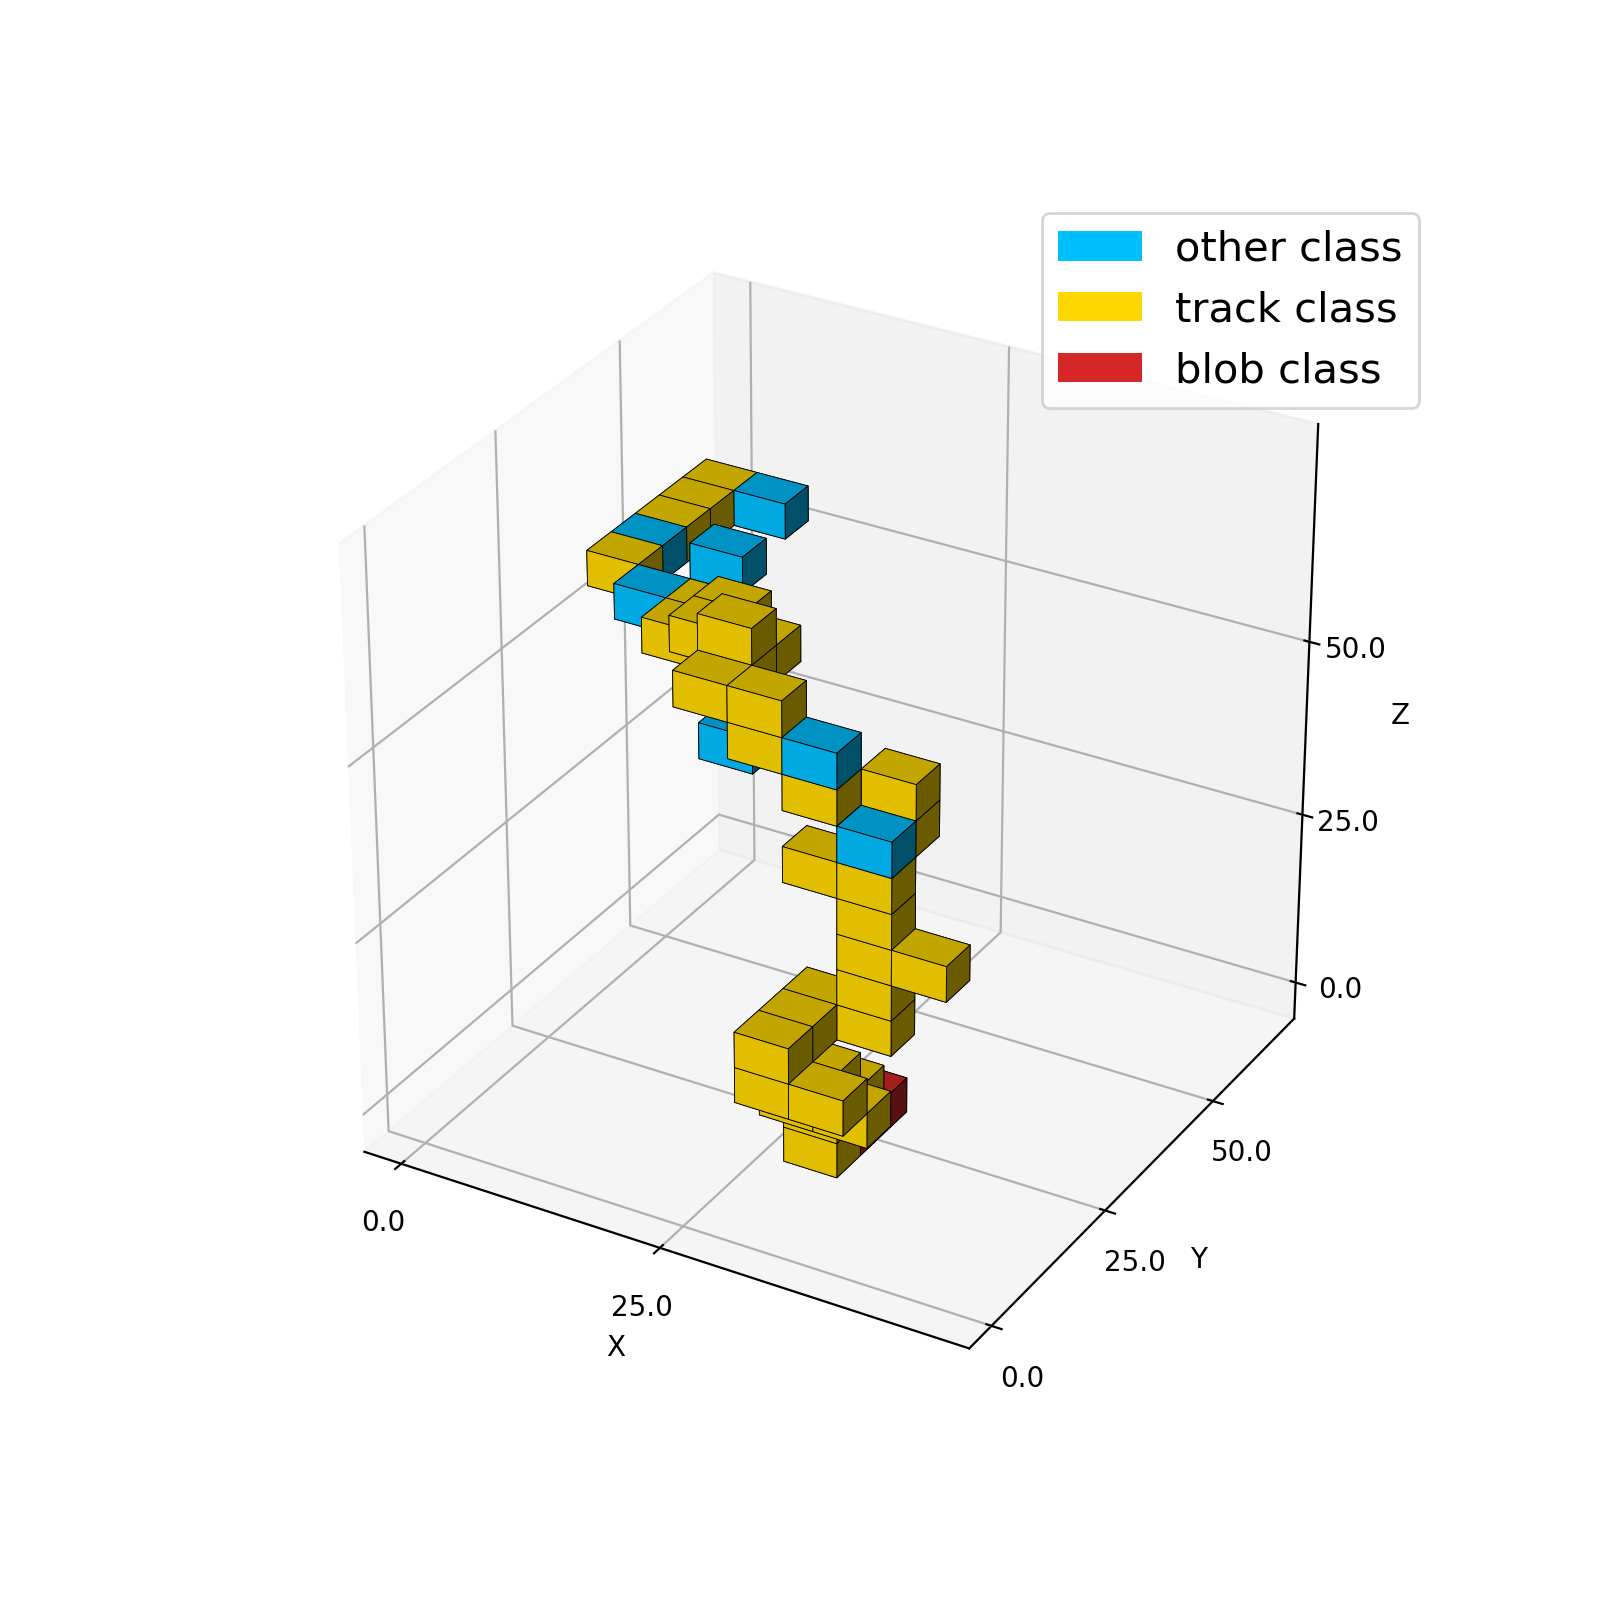

In [54]:
plot_cloud_voxels_and_hits_discrete(event_voxels, event_hits, 
                                    voxel_size, start_bin, 
                                    coords = ['xbin', 'ybin', 'zbin'], 
                                    #value = ['energy', 'energy', 'energy'],
                                    opacity = [1, 0, 0])

<IPython.core.display.Javascript object>


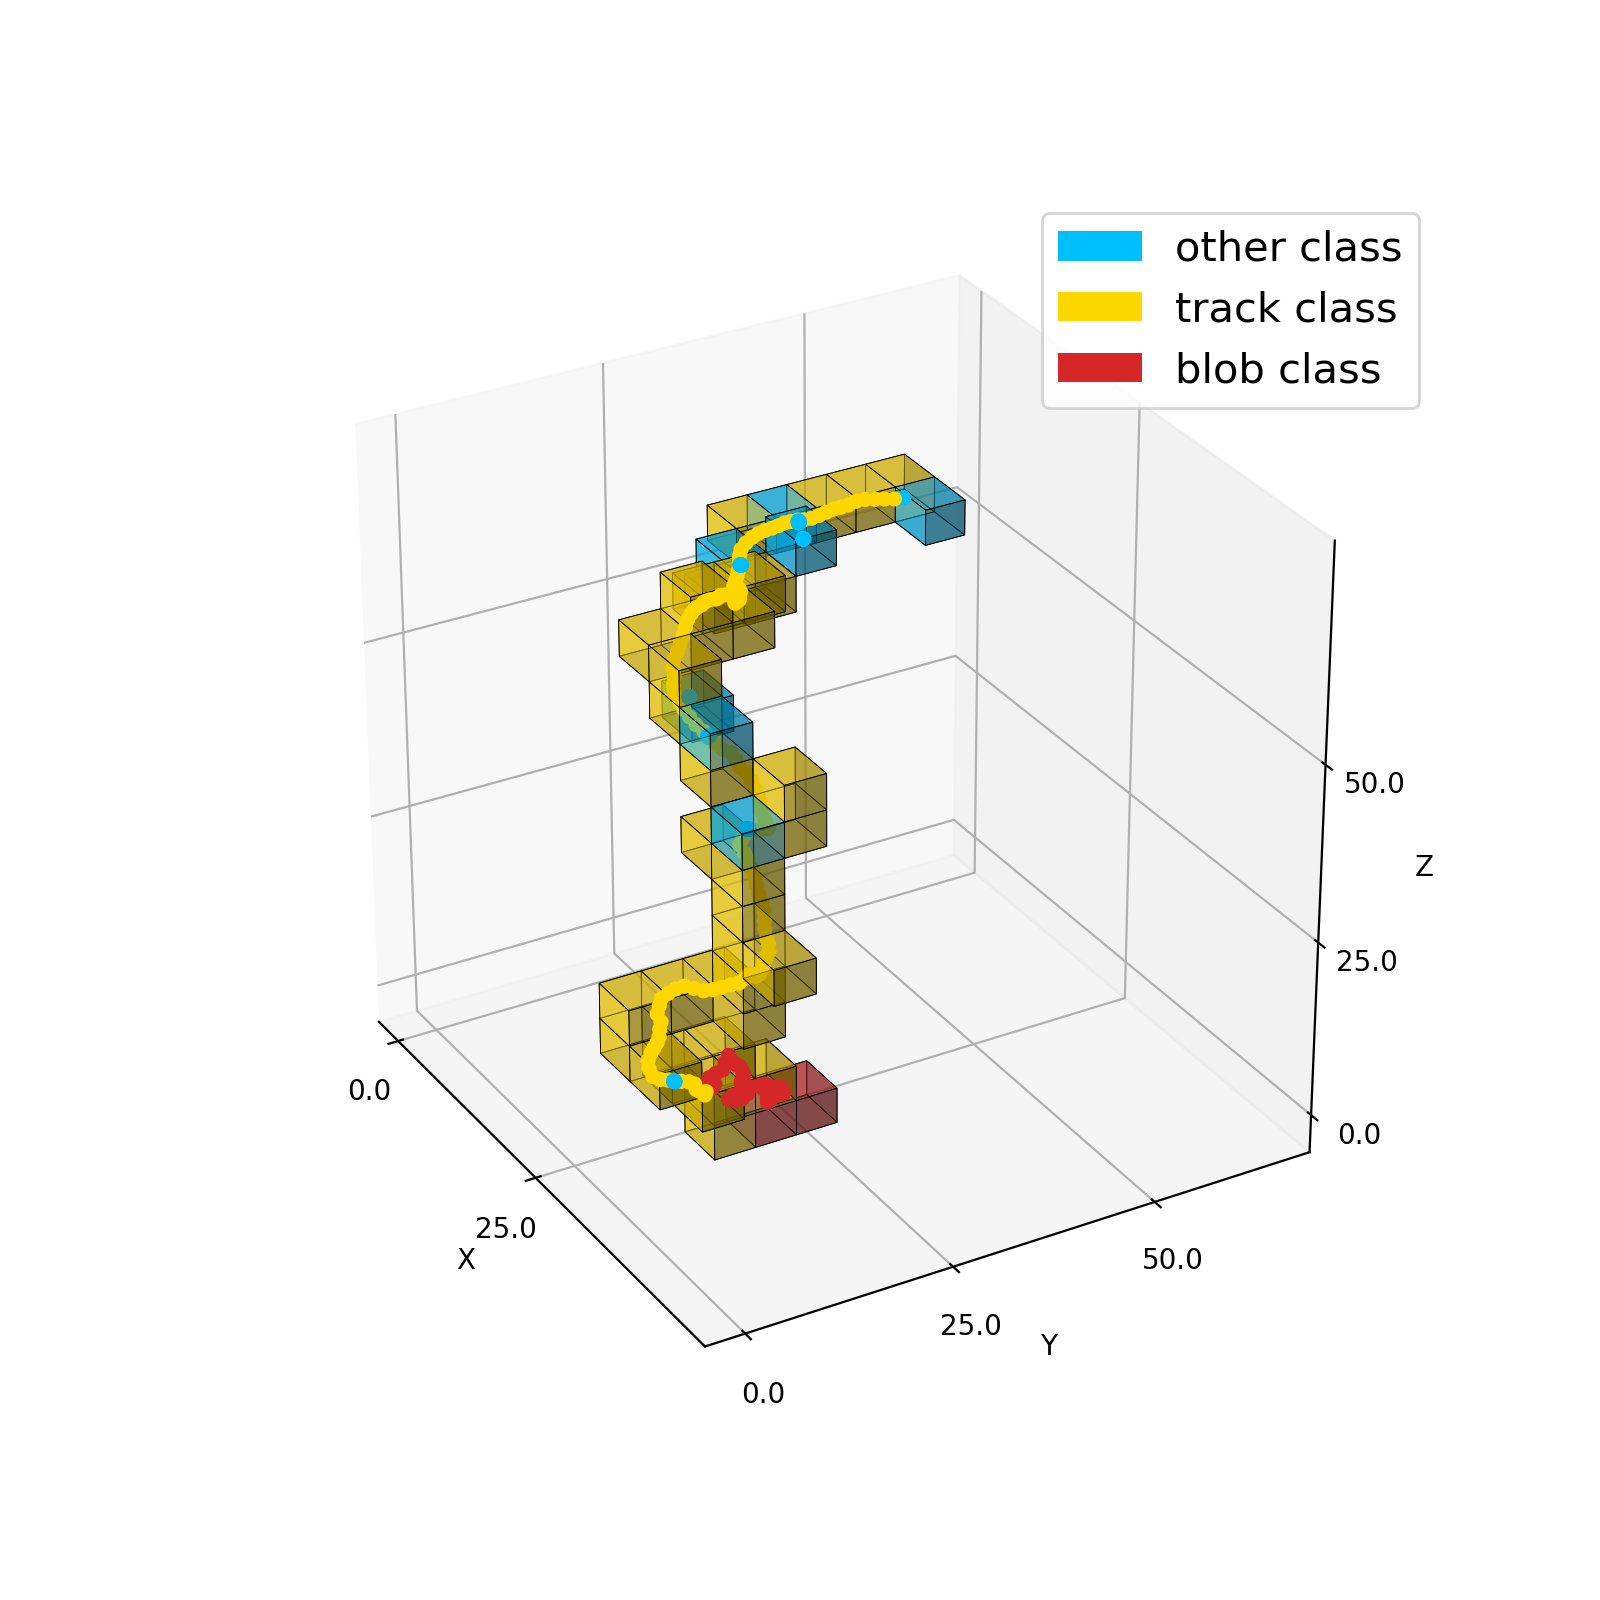

In [52]:
plot_cloud_voxels_and_hits_discrete(event_voxels, event_hits, 
                                    voxel_size, start_bin, 
                                    coords = ['xbin', 'ybin', 'zbin'], 
                                    #value = ['energy', 'energy', 'energy'],
                                    opacity = [0.5, 0, 1])

To run this function run the following cell with the function first

<IPython.core.display.Javascript object>


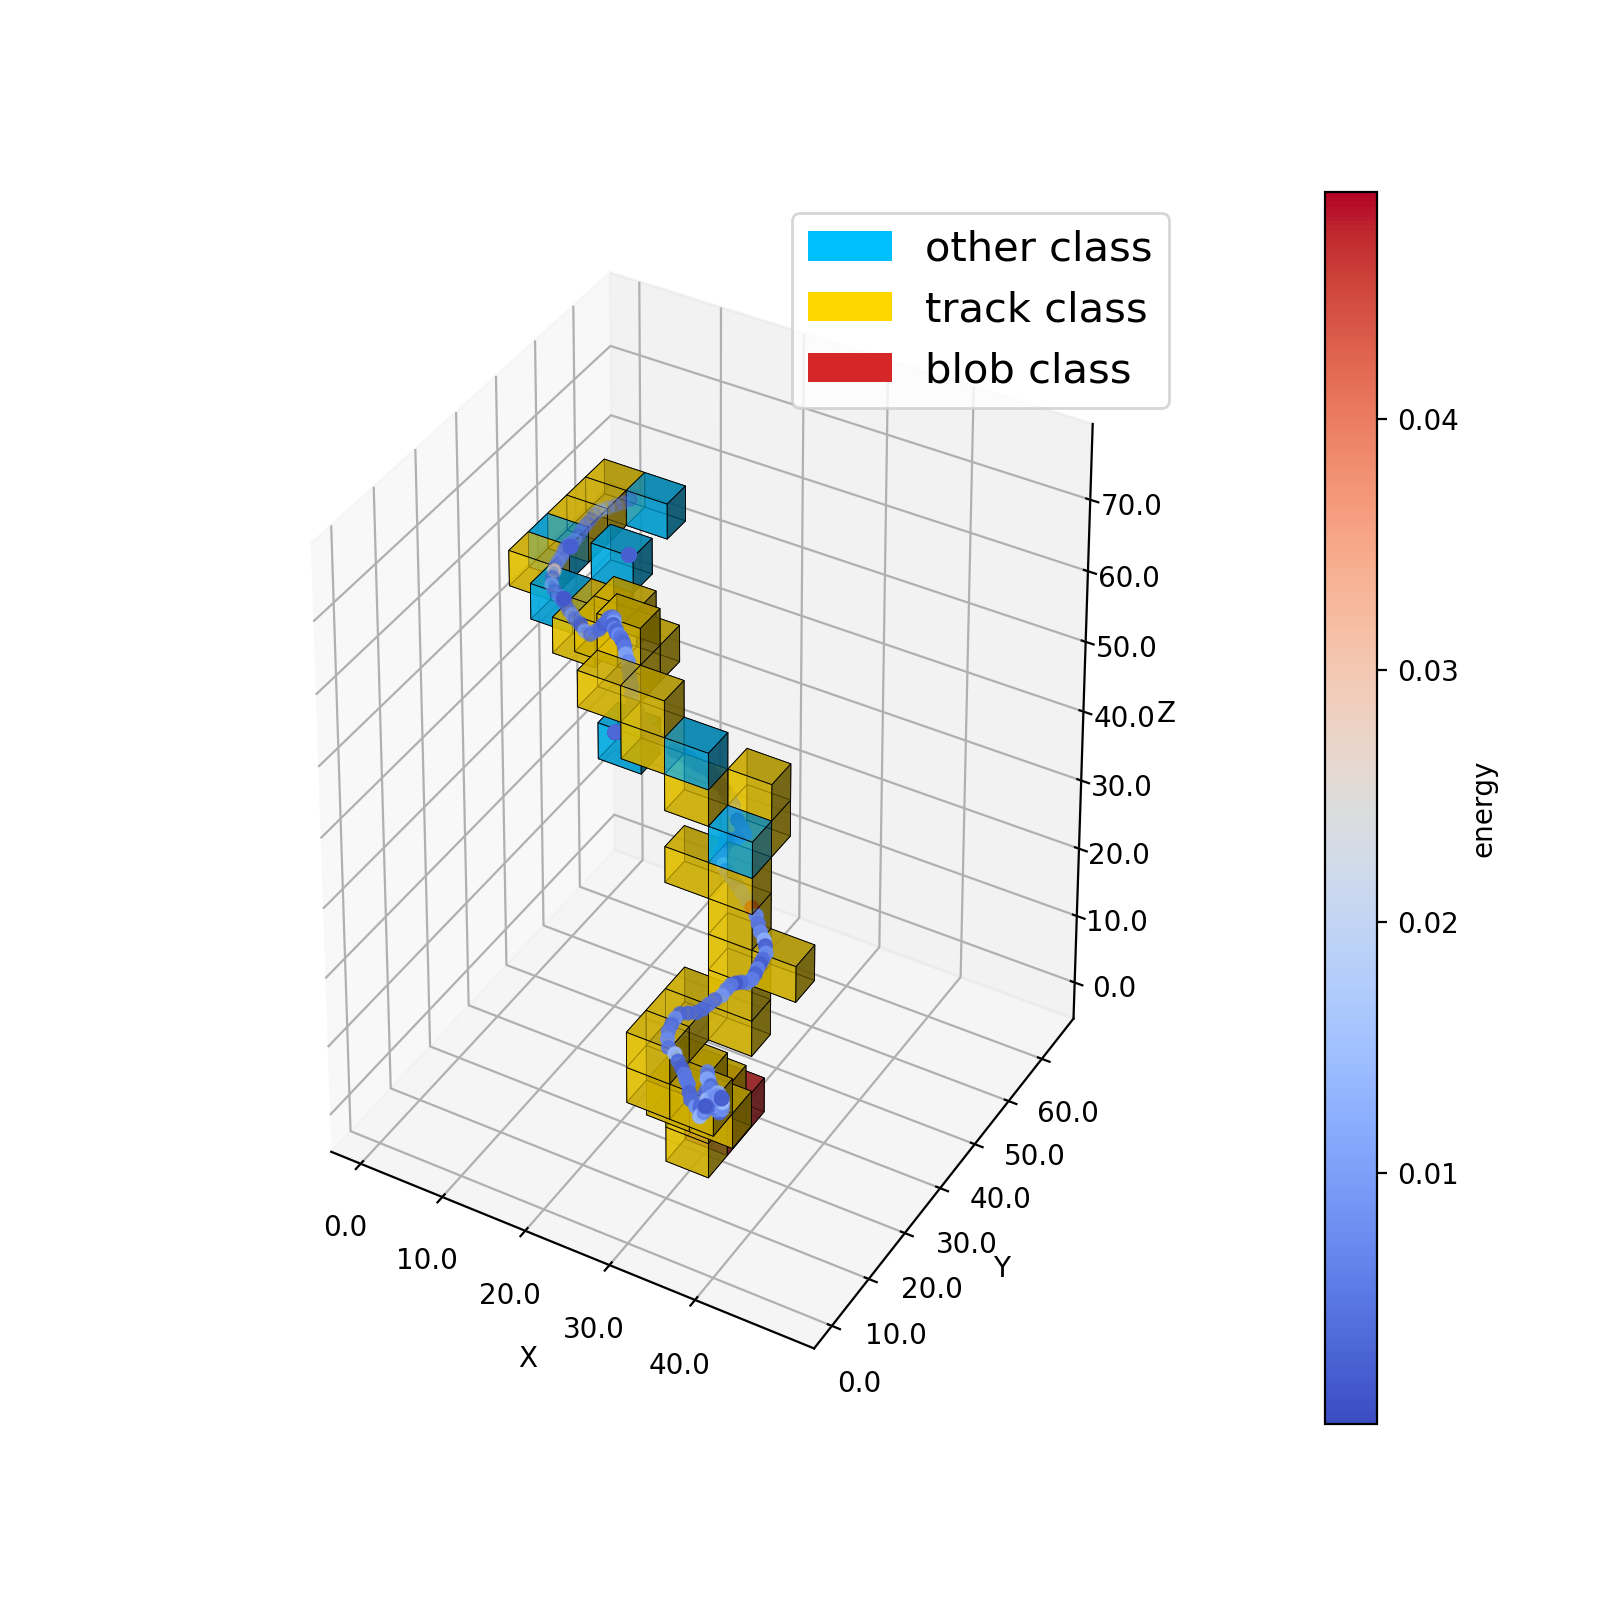

In [151]:
plot_discrvox_and_hits(event_voxels, 
                           event_hits, 
                           voxel_size, 
                           start_bin, 
                           value = ['segclass', 'energy'], 
                           voxel_coords = ['xbin', 'ybin', 'zbin'], 
                           hits_coords = ['x', 'y', 'z'], 
                           opacity = [0.7, 1])

In [28]:
def plot_discrvox_and_hits(labelled_voxels, 
                           labelled_hits, 
                           voxel_size, 
                           start_bin, 
                           value = ['segclass', 'energy'], 
                           affluence = (2, 2, 2),
                           voxel_coords = ['xbin', 'ybin', 'zbin'], 
                           hits_coords = ['x', 'y', 'z'],
                           edgecolor = 'k', 
                           linewidth = .3, 
                           opacity = [1, 1],
                           cmap = mpl.cm.coolwarm):
    color_dict = {1:'deepskyblue', 2:'gold', 3:'tab:red', 4:'deepskyblue', 5:'gold', 6:'tab:red', 7:'tab:green'}


    xcoord  = labelled_voxels[voxel_coords[0]].values
    ycoord  = labelled_voxels[voxel_coords[1]].values
    zcoord  = labelled_voxels[voxel_coords[2]].values
    content = labelled_voxels[value[0]].values

    xmin, xmax = min(xcoord), max(xcoord)
    ymin, ymax = min(ycoord), max(ycoord)
    zmin, zmax = min(zcoord), max(zcoord)

    labels, ticks = plot_label_creator((xmin, ymin, zmin), (xmax, ymax, zmax), voxel_size, affluence)

    nbinsX = int(np.ceil((xmax-xmin))) + 2
    nbinsY = int(np.ceil((ymax-ymin))) + 2
    nbinsZ = int(np.ceil((zmax-zmin))) + 2
    
    mc_label = labelled_voxels[np.isin(labelled_voxels.segclass, (1, 2, 3))]
    
    
    fig  = plt.figure(figsize=(8, 8), frameon=False)
    gs   = fig.add_gridspec(1, 20)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    
    #voxels
    xarr = np.zeros(shape=(nbinsX, nbinsY, nbinsZ), dtype = 'U16')

    nonzeros = np.vstack([mc_label[voxel_coords[0]].values-xmin,
                          mc_label[voxel_coords[1]].values-ymin,
                          mc_label[voxel_coords[2]].values-zmin])

    xarr[tuple(nonzeros)] = mc_label[value[0]].map(color_dict).values


    ax.voxels(xarr, facecolors=xarr, edgecolor=edgecolor, linewidth = linewidth, alpha = opacity[0])

    legend_elements = [Patch(facecolor='deepskyblue', label='other class'),
                       Patch(facecolor='gold',        label='track class'),
                       Patch(facecolor='tab:red',     label='blob class')]
    
    #HITS
    scaled_hits = plot_adaption_hits_to_voxel_scale(labelled_hits, voxel_size, start_bin)

    axcb = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=scaled_hits.loc[:, value[1]].min(), vmax=scaled_hits.loc[:, value[1]].max())

    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = np.asarray(np.vectorize(m.to_rgba)(scaled_hits.loc[:, value[1]]))
    colors = np.rollaxis(colors, 0, 2)

    ax.scatter(scaled_hits[hits_coords[0]] - xmin, scaled_hits[hits_coords[1]] - ymin, scaled_hits[hits_coords[2]] - zmin, c=colors * opacity[1], marker='o')
    cb_hits = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')

    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')

    ax.set_xticklabels(labels[0])
    ax.set_xticks(ticks[0])
    ax.set_yticklabels(labels[1])
    ax.set_yticks(ticks[1])
    ax.set_zticklabels(labels[2])
    ax.set_zticks(ticks[2])
    
    cb_hits.set_label(value[1])
    
    ax.legend(handles=legend_elements, fontsize=15)
    
    plt.show()